In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds


from modules.se import SE3d
from modules.ball_query import BallQuery
from modules.shared_mlp import SharedMLP
from modules.voxelization import Voxelization
import modules.functional as F

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [38]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


# Now we want to augment the data points by adding Gaussian noise with 0 mean and 0.025 standard deviation

In [39]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

Number of CPU cores: 32


In [40]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [41]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(2832, 405, 808)

# Let's see how the shapes change by adding this amount of noise

In [42]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

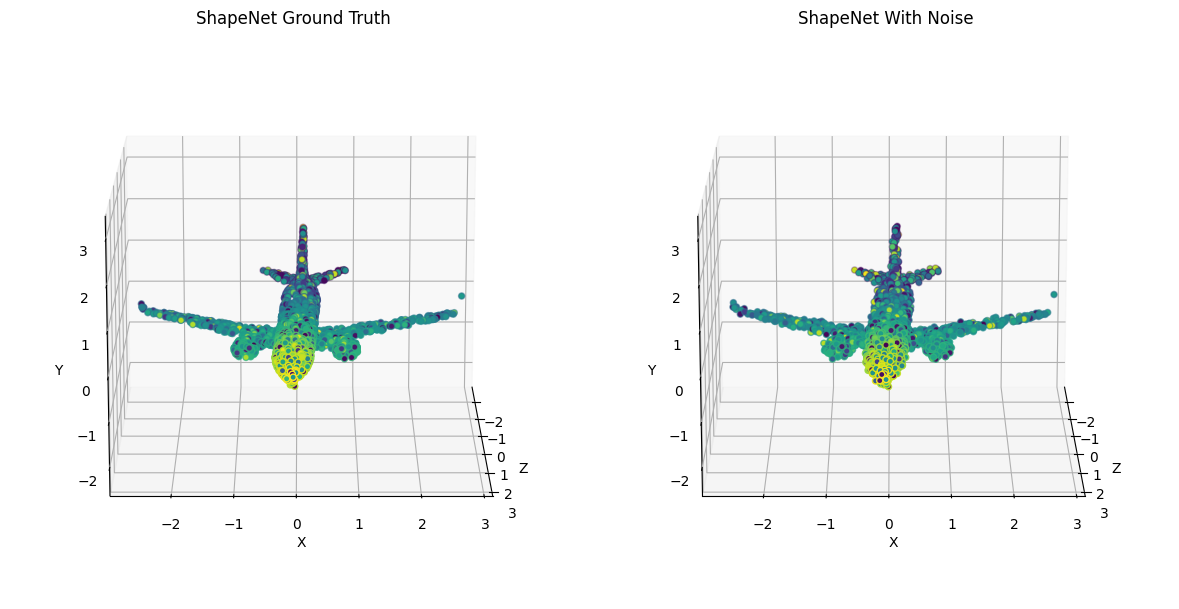

In [43]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda").transpose(1,2)
    input_np = input[2, :, :].squeeze().transpose(0, 1).detach().cpu().numpy()

    input_noise = add_random_noise(input)
    input_np_noise = input_noise[2, :, :].squeeze().transpose(0, 1).detach().cpu().numpy()

    fig = visualize_pointcloud_eval(input_np, input_np_noise, "ShapeNet Ground Truth", "ShapeNet With Noise")
    break

# Define PVCNN Architecture

In [44]:
class PointNetAModule(nn.Module):
    def __init__(self, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]]
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels]

        mlps = []
        total_out_channels = 0
        for _out_channels in out_channels:
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=1)
            )
            total_out_channels += _out_channels[-1]

        self.include_coordinates = include_coordinates
        self.out_channels = total_out_channels
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        if self.include_coordinates:
            features = torch.cat([features, coords], dim=1)
        coords = torch.zeros((coords.size(0), 3, 1), device=coords.device)
        if len(self.mlps) > 1:
            features_list = []
            for mlp in self.mlps:
                features_list.append(mlp(features).max(dim=-1, keepdim=True).values)
            return torch.cat(features_list, dim=1), coords
        else:
            return self.mlps[0](features).max(dim=-1, keepdim=True).values, coords

    def extra_repr(self):
        return f'out_channels={self.out_channels}, include_coordinates={self.include_coordinates}'


class PointNetSAModule(nn.Module):
    def __init__(self, num_centers, radius, num_neighbors, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(radius, (list, tuple)):
            radius = [radius]
        if not isinstance(num_neighbors, (list, tuple)):
            num_neighbors = [num_neighbors] * len(radius)
        assert len(radius) == len(num_neighbors)
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]] * len(radius)
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels] * len(radius)
        assert len(radius) == len(out_channels)

        groupers, mlps = [], []
        total_out_channels = 0
        for _radius, _out_channels, _num_neighbors in zip(radius, out_channels, num_neighbors):
            groupers.append(
                BallQuery(radius=_radius, num_neighbors=_num_neighbors, include_coordinates=include_coordinates)
            )
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=2)
            )
            total_out_channels += _out_channels[-1]

        self.num_centers = num_centers
        self.out_channels = total_out_channels
        self.groupers = nn.ModuleList(groupers)
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        centers_coords = F.furthest_point_sample(coords, self.num_centers)
        features_list = []
        for grouper, mlp in zip(self.groupers, self.mlps):
            features_list.append(mlp(grouper(coords, centers_coords, features)).max(dim=-1).values)
        if len(features_list) > 1:
            return torch.cat(features_list, dim=1), centers_coords
        else:
            return features_list[0], centers_coords

    def extra_repr(self):
        return f'num_centers={self.num_centers}, out_channels={self.out_channels}'


class PointNetFPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = SharedMLP(in_channels=in_channels, out_channels=out_channels, dim=1)

    def forward(self, inputs):
        if len(inputs) == 3:
            points_coords, centers_coords, centers_features = inputs
            points_features = None
        else:
            points_coords, centers_coords, centers_features, points_features = inputs
        interpolated_features = F.nearest_neighbor_interpolate(points_coords, centers_coords, centers_features)
        if points_features is not None:
            interpolated_features = torch.cat(
                [interpolated_features, points_features], dim=1
            )
        return self.mlp(interpolated_features), points_coords

In [45]:
class PVConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, resolution, with_se=False, normalize=True, eps=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.resolution = resolution

        self.voxelization = Voxelization(resolution, normalize=normalize, eps=eps)
        voxel_layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
            nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
         ]
        if with_se:
            voxel_layers.append(SE3d(out_channels))
        self.voxel_layers = nn.Sequential(*voxel_layers)
        self.point_features = SharedMLP(in_channels, out_channels)

    def forward(self, inputs):
        features, coords = inputs
        voxel_features, voxel_coords = self.voxelization(features, coords)
        voxel_features = self.voxel_layers(voxel_features)
        voxel_features = F.trilinear_devoxelize(voxel_features, voxel_coords, self.resolution, self.training)
        fused_features = voxel_features + self.point_features(features)
        return fused_features, coords

In [46]:
def _linear_bn_relu(in_channels, out_channels):
    return nn.Sequential(nn.Linear(in_channels, out_channels), nn.BatchNorm1d(out_channels), nn.ReLU(True))


def create_mlp_components(in_channels, out_channels, classifier=False, dim=2, width_multiplier=1):
    r = width_multiplier

    if dim == 1:
        block = _linear_bn_relu
    else:
        block = SharedMLP
    if not isinstance(out_channels, (list, tuple)):
        out_channels = [out_channels]
    if len(out_channels) == 0 or (len(out_channels) == 1 and out_channels[0] is None):
        return nn.Sequential(), in_channels, in_channels

    layers = []
    for oc in out_channels[:-1]:
        if oc < 1:
            layers.append(nn.Dropout(oc))
        else:
            oc = int(r * oc)
            layers.append(block(in_channels, oc))
            in_channels = oc
    if dim == 1:
        if classifier:
            layers.append(nn.Linear(in_channels, out_channels[-1]))
        else:
            layers.append(_linear_bn_relu(in_channels, int(r * out_channels[-1])))
    else:
        if classifier:
            layers.append(nn.Conv1d(in_channels, out_channels[-1], 1))
        else:
            layers.append(SharedMLP(in_channels, int(r * out_channels[-1])))
    return layers, out_channels[-1] if classifier else int(r * out_channels[-1])


def create_pointnet_components(blocks, in_channels, with_se=False, normalize=True, eps=0,
                               width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    layers, concat_channels = [], 0
    for out_channels, num_blocks, voxel_resolution in blocks:
        out_channels = int(r * out_channels)
        if voxel_resolution is None:
            block = SharedMLP
        else:
            block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                      with_se=with_se, normalize=normalize, eps=eps)
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels))
            in_channels = out_channels
            concat_channels += out_channels
    return layers, in_channels, concat_channels


def create_pointnet2_sa_components(sa_blocks, extra_feature_channels, with_se=False, normalize=True, eps=0,
                                   width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier
    in_channels = extra_feature_channels + 3

    sa_layers, sa_in_channels = [], []
    for conv_configs, sa_configs in sa_blocks:
        sa_in_channels.append(in_channels)
        sa_blocks = []
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                sa_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
            extra_feature_channels = in_channels
        num_centers, radius, num_neighbors, out_channels = sa_configs
        _out_channels = []
        for oc in out_channels:
            if isinstance(oc, (list, tuple)):
                _out_channels.append([int(r * _oc) for _oc in oc])
            else:
                _out_channels.append(int(r * oc))
        out_channels = _out_channels
        if num_centers is None:
            block = PointNetAModule
        else:
            block = functools.partial(PointNetSAModule, num_centers=num_centers, radius=radius,
                                      num_neighbors=num_neighbors)
        sa_blocks.append(block(in_channels=extra_feature_channels, out_channels=out_channels,
                               include_coordinates=True))
        in_channels = extra_feature_channels = sa_blocks[-1].out_channels
        if len(sa_blocks) == 1:
            sa_layers.append(sa_blocks[0])
        else:
            sa_layers.append(nn.Sequential(*sa_blocks))

    return sa_layers, sa_in_channels, in_channels, 1 if num_centers is None else num_centers


def create_pointnet2_fp_modules(fp_blocks, in_channels, sa_in_channels, with_se=False, normalize=True, eps=0,
                                width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    fp_layers = []
    for fp_idx, (fp_configs, conv_configs) in enumerate(fp_blocks):
        fp_blocks = []
        out_channels = tuple(int(r * oc) for oc in fp_configs)
        fp_blocks.append(
            PointNetFPModule(in_channels=in_channels + sa_in_channels[-1 - fp_idx], out_channels=out_channels)
        )
        in_channels = out_channels[-1]
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                fp_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
        if len(fp_blocks) == 1:
            fp_layers.append(fp_blocks[0])
        else:
            fp_layers.append(nn.Sequential(*fp_blocks))

    return fp_layers, in_channels

In [47]:
class PVCNN(nn.Module):
    blocks = ((64, 1, 32), (128, 2, 16), (512, 1, None), (2048, 1, None))

    def __init__(self, num_classes, num_shapes, extra_feature_channels=3,
                 width_multiplier=1, voxel_resolution_multiplier=1):
        super().__init__()
        assert extra_feature_channels >= 0
        self.in_channels = extra_feature_channels + 3
        self.num_shapes = num_shapes

        layers, channels_point, concat_channels_point = create_pointnet_components(
            blocks=self.blocks, in_channels=self.in_channels, with_se=True, normalize=False,
            width_multiplier=width_multiplier, voxel_resolution_multiplier=voxel_resolution_multiplier
        )
        self.point_features = nn.ModuleList(layers)

        layers, _ = create_mlp_components(in_channels=(num_shapes + channels_point + concat_channels_point),
                                          out_channels=[256, 0.2, 256, 0.2, 128, num_classes],
                                          classifier=True, dim=2, width_multiplier=width_multiplier)
        self.classifier = nn.Sequential(*layers)

    def forward(self, inputs):
        # inputs : [B, in_channels + S, N]
        features = inputs[:, :self.in_channels, :]
        one_hot_vectors = inputs[:, -self.num_shapes:, :]
        num_points = features.size(-1)

        coords = features[:, :3, :]
        out_features_list = [one_hot_vectors]
        for i in range(len(self.point_features)):
            features, _ = self.point_features[i]((features, coords))
            out_features_list.append(features)
        out_features_list.append(features.max(dim=-1, keepdim=True).values.repeat([1, 1, num_points]))
        return self.classifier(torch.cat(out_features_list, dim=1))

In [48]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

# Let's train the PVCNN

In [49]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [50]:
noise = torch.normal(0, 1, size=(20, 3, 256)).to("cuda")
output = model(noise)

noise.shape, output.shape

(torch.Size([20, 3, 256]), torch.Size([20, 3, 256]))

In [51]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda")

In [52]:
input.shape

torch.Size([20, 2048, 3])

In [53]:
from pytorch3d.ops import knn_points

def get_nearest_neighbors_batch_pytorch3d(batch, N):
    """
    For each point cloud in the batch, select a random point and find its N nearest neighbors using PyTorch3D.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param N: Number of nearest neighbors to find
    :return: Tensor of nearest neighbors of size [batch_size, N, num_channels]
    """
    batch_size, num_points, _ = batch.shape

    # Select a random point from each point cloud in the batch
    indices = torch.randint(0, num_points, (batch_size,)).to(batch.device)
    selected_points = batch[torch.arange(batch_size), indices].unsqueeze(1)

    # Use knn from PyTorch3D
    knn_result = knn_points(selected_points, batch, K=N)

    nn_idx = knn_result.idx.squeeze()

    # Add an extra dimension to selected_points to make it [20, 255, 1]
    selected_points_expanded = nn_idx.unsqueeze(-1)

    # Expand selected_points to match the last dimension of input_tensor
    selected_points_expanded = selected_points_expanded.expand(-1, -1, batch.shape[-1])

    # Gather the points from the input_tensor
    result = torch.gather(batch, 1, selected_points_expanded)

    result = torch.cat([result, selected_points], dim=1)

    return result

In [54]:
patched_batch = get_nearest_neighbors_batch_pytorch3d(input, 511)

In [55]:
patched_batch.shape

torch.Size([20, 512, 3])

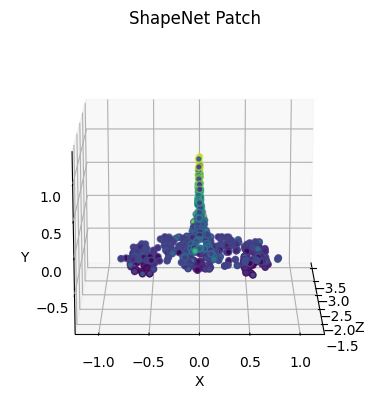

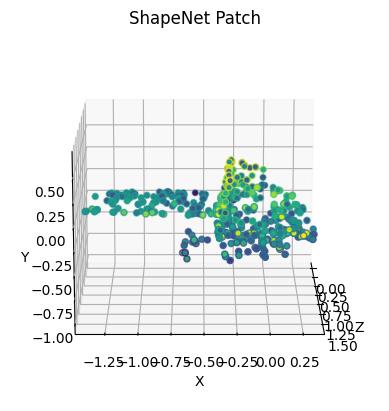

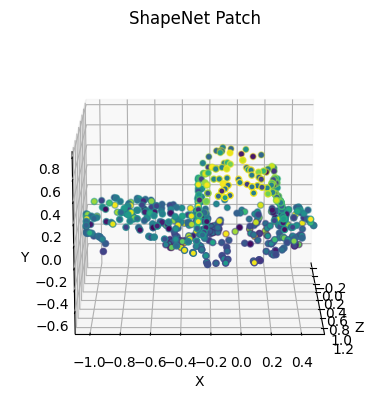

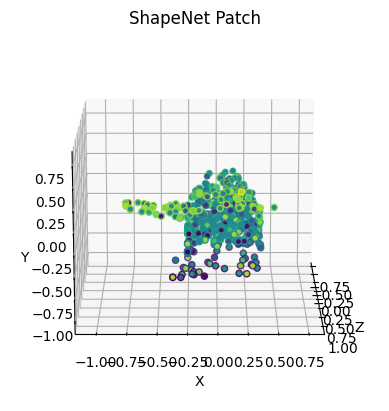

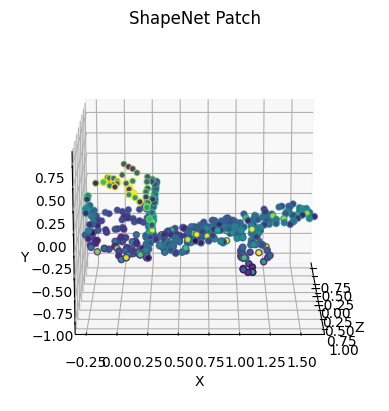

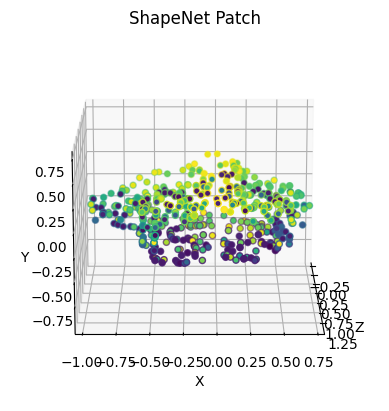

In [56]:
i = 1
for sample in patched_batch:
    input_np = sample.squeeze().detach().cpu().numpy()
    fig = visualize_pointcloud(input_np, "ShapeNet Patch")
    
    if i > 5:
        break

    i += 1

# Patching functions

In [57]:
def get_nearest_neighbors_batch_pytorch3d_indicies(batch, N):
    """
    For each point cloud in the batch, select a random point and find its N nearest neighbors using PyTorch3D.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param N: Number of nearest neighbors to find
    :return: Tensor of nearest neighbors of size [batch_size, N, num_channels]
    """
    batch_size, num_points, _ = batch.shape

    # Select a random point from each point cloud in the batch
    indices = torch.randint(0, num_points, (batch_size,)).to(batch.device)
    selected_points = batch[torch.arange(batch_size), indices].unsqueeze(1)

    # Use knn from PyTorch3D
    knn_result = knn_points(selected_points, batch, K=N)

    nn_idx = knn_result.idx.squeeze()

    # Add an extra dimension to selected_points to make it [20, 255, 1]
    selected_points_expanded = nn_idx.unsqueeze(-1)

    # Expand selected_points to match the last dimension of input_tensor
    selected_points_expanded = selected_points_expanded.expand(-1, -1, batch.shape[-1])

    # Gather the points from the input_tensor
    result = torch.gather(batch, 1, selected_points_expanded)

    return result, nn_idx

In [58]:
def generate_non_overlapping_patches(batch, patch_size=512):
    """
    Generate non-overlapping patches from a point cloud batch.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param patch_size: Size of each patch
    :return: A list of 4 tensors, each of size [batch_size, patch_size, num_channels]
    """
    batch_size, num_points, _ = batch.shape

    assert num_points % patch_size == 0
    iterations = num_points // patch_size

    input = batch.clone()

    patches = []
    for i in range(iterations - 1):
        # Use the existing function to get a patch from this section
        patch, indicies = get_nearest_neighbors_batch_pytorch3d_indicies(input, patch_size)

        # Remove the selected points
        # Create a mask with all True values
        mask = torch.ones(input.shape[:2], dtype=torch.bool)

        # Iterate over each batch to update the mask
        for i in range(indicies.shape[0]):
            mask[i, indicies[i]] = False

        # Apply the mask to the input tensor
        # The mask is broadcasted to match the shape of input_tensor
        input = input[mask].view(20, -1, 3)

        patches.append(patch)

    patches.append(input)

    return torch.stack(patches)

## Training with a single patch

In [74]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Patch'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")

        # Random patch
        patched_input = get_nearest_neighbors_batch_pytorch3d(input, 511).transpose(1,2)

        # Add noise to the input
        noised_patched_input = add_random_noise(patched_input)
        
        optimizer.zero_grad()
        output = model(noised_patched_input).to("cuda")

        loss = chamfer_distance(patched_input.transpose(1,2), output.transpose(1,2))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")

            # Random patch
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, 511).transpose(1,2)

            # Add noise to the input
            noised_patched_input = add_random_noise(patched_input)
            
            output = model(noised_patched_input).to("cuda")
            val_loss = chamfer_distance(patched_input.transpose(1,2), output.transpose(1,2))

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-patch/PVCNN-Baseline-Refinement-Patch-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0688, Validation Loss: 0.0620
Epoch 2,  Training Loss: 0.0234, Validation Loss: 0.0242
Epoch 3,  Training Loss: 0.0160, Validation Loss: 0.0157
Epoch 4,  Training Loss: 0.0119, Validation Loss: 0.0078
Epoch 5,  Training Loss: 0.0106, Validation Loss: 0.0067
Epoch 6,  Training Loss: 0.0088, Validation Loss: 0.0057
Epoch 7,  Training Loss: 0.0080, Validation Loss: 0.0068
No improvement in validation loss for 1 epochs.
Epoch 8,  Training Loss: 0.0072, Validation Loss: 0.0053
Epoch 9,  Training Loss: 0.0068, Validation Loss: 0.0051
Epoch 10,  Training Loss: 0.0064, Validation Loss: 0.0068
No improvement in validation loss for 1 epochs.
Epoch 11,  Training Loss: 0.0061, Validation Loss: 0.0046
Epoch 12,  Training Loss: 0.0060, Validation Loss: 0.0047
No improvement in validation loss for 1 epochs.
Epoch 13,  Training Loss: 0.0058, Validation Loss: 0.0039
Epoch 14,  Training Loss: 0.0053, Validation Loss: 0.0046
No improvement in validation loss for 1 epochs.
Epoch

## Training with multiple patches

In [27]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Patches'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        # Add noise to the patched input
        noised_patched_input = add_random_noise(patched_input)

        optimizer.zero_grad()
        denoised_patches = []
        for noised_patch in noised_patched_input:
            output = model(noised_patch).to("cuda")
            denoised_patches.append(output)

        output = torch.stack(denoised_patches).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)
        loss = chamfer_distance(input, output)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()


    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["test_points"].to("cuda")
            patched_input = generate_non_overlapping_patches(input).transpose(2,3)
            
            # Add noise to the patched input
            noised_patched_input = add_random_noise(patched_input)

            denoised_patches = []
            for noised_patch in noised_patched_input:
                output = model(noised_patch).to("cuda")
                denoised_patches.append(output)

            output = torch.stack(denoised_patches).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)
            
            val_loss = chamfer_distance(input, output)

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-patches/PVCNN-Baseline-Refinement-Patches-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0471, Validation Loss: 0.1268


KeyboardInterrupt: 

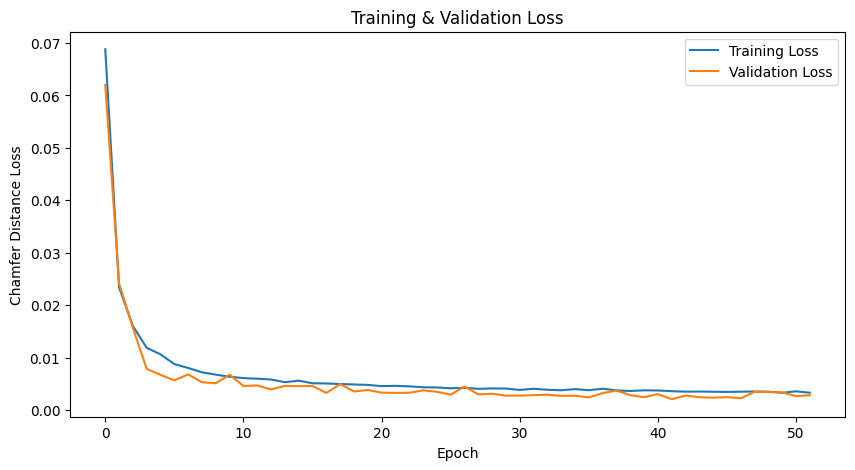

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

# Let's visualize some examples

In [59]:
# Run this if you need to load the model.

model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-refinement-patch/PVCNN-Baseline-Refinement-Patch-e51.pth"))

<All keys matched successfully>

In [62]:
model.eval()

with torch.no_grad():
    for batch in val_dataloader:
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        # Add noise to the patched input
        noised_patched_input = add_random_noise(patched_input)

        denoised_patches = []
        for noised_patch in noised_patched_input:
            output = model(noised_patch).to("cuda")
            denoised_patches.append(output)

        output = torch.stack(denoised_patches).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)
        break

In [67]:
output.shape

torch.Size([20, 2048, 3])

In [68]:
patched_input = patched_input.transpose(0,1).transpose(2,3)
patched_input.shape

torch.Size([20, 4, 512, 3])

In [64]:
denoised_patches_tensor = torch.stack(denoised_patches).transpose(2,3).transpose(0,1)
denoised_patches_tensor.shape

torch.Size([20, 4, 512, 3])

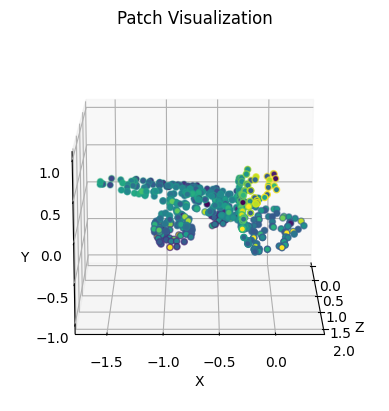

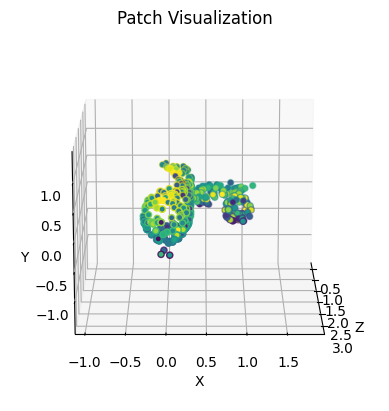

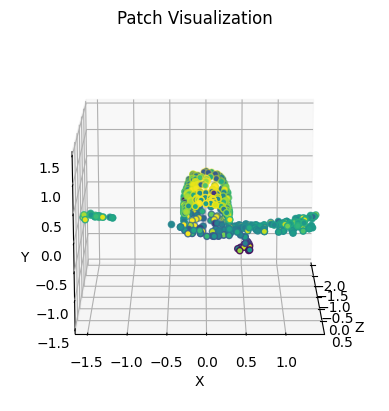

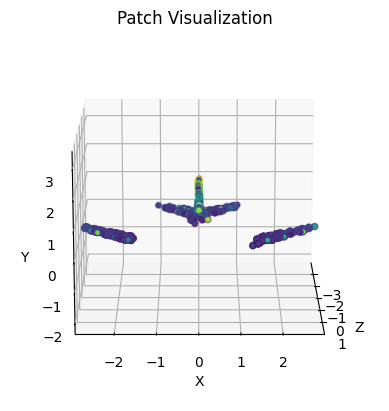

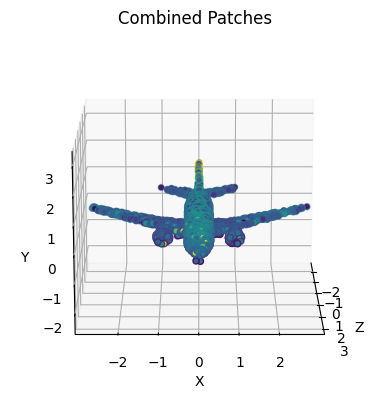

In [71]:
for patches in patched_input:
    for patch in patches:
        input_np = patch.squeeze().detach().cpu().numpy()
        fig = visualize_pointcloud(input_np, "Patch Visualization")
    
    visualize_pointcloud(patches.reshape(2048,3).squeeze().detach().cpu().numpy(), "Combined Patches")
    break

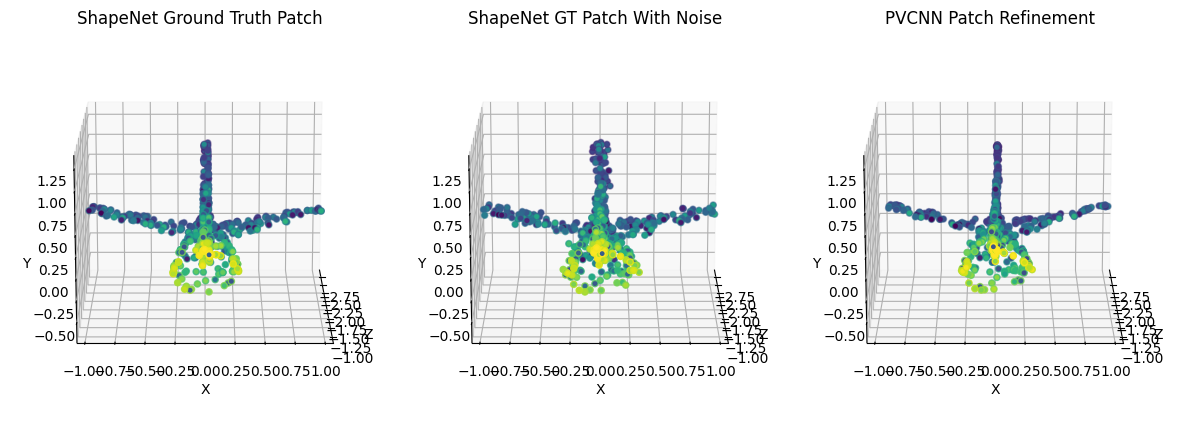

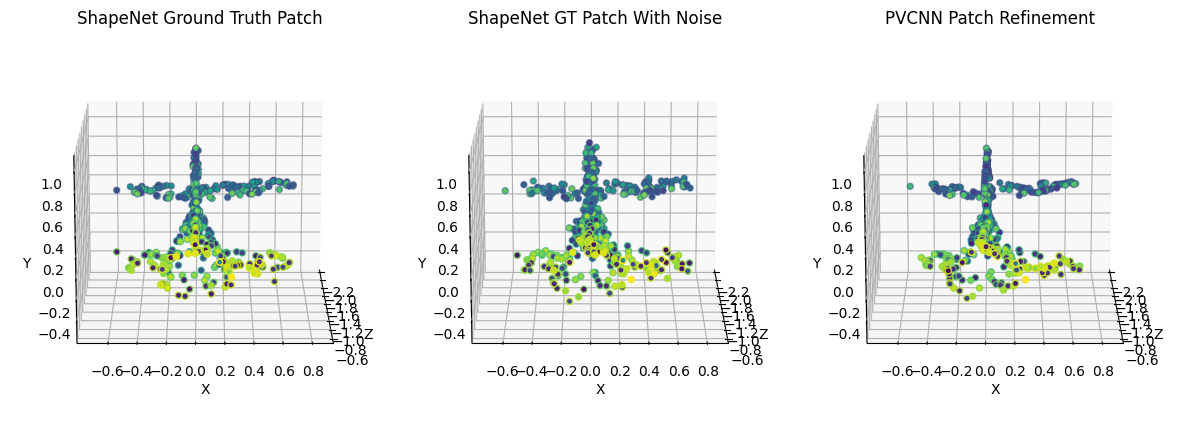

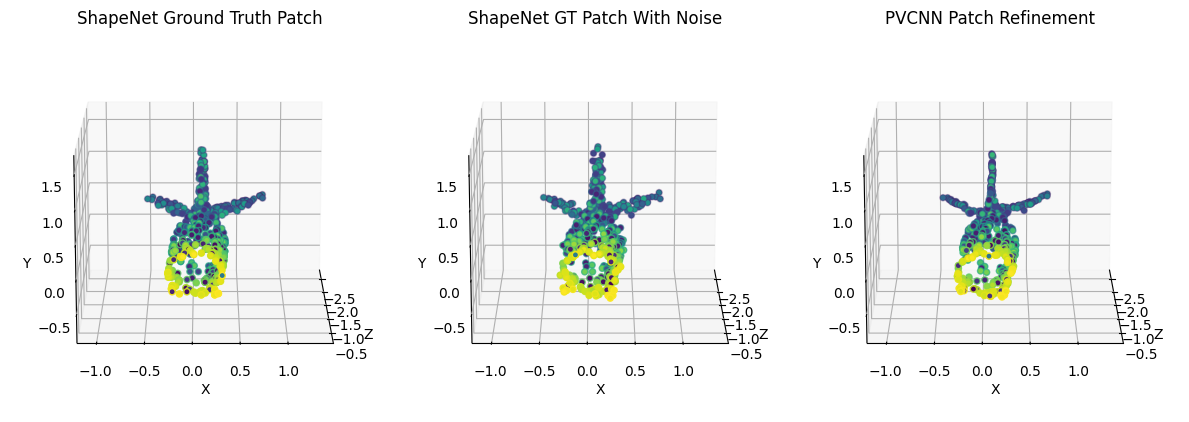

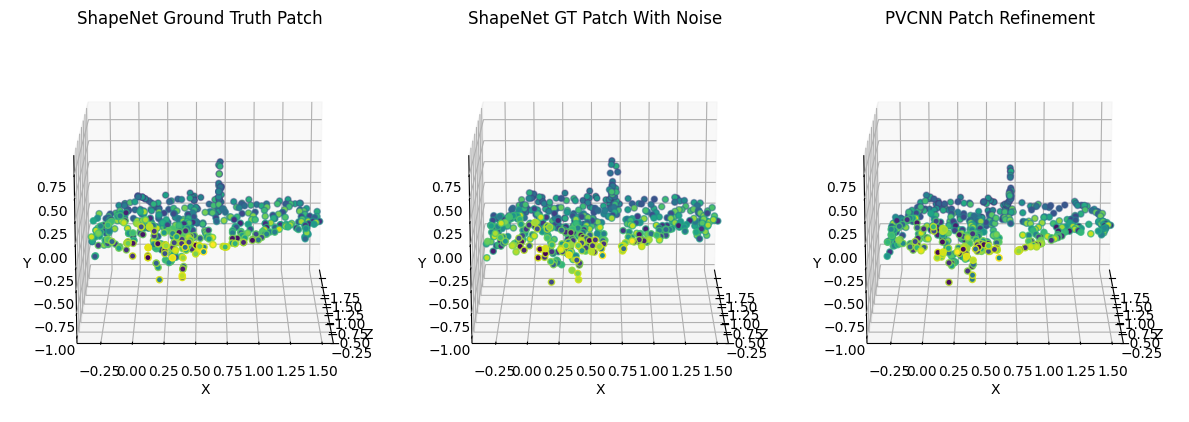

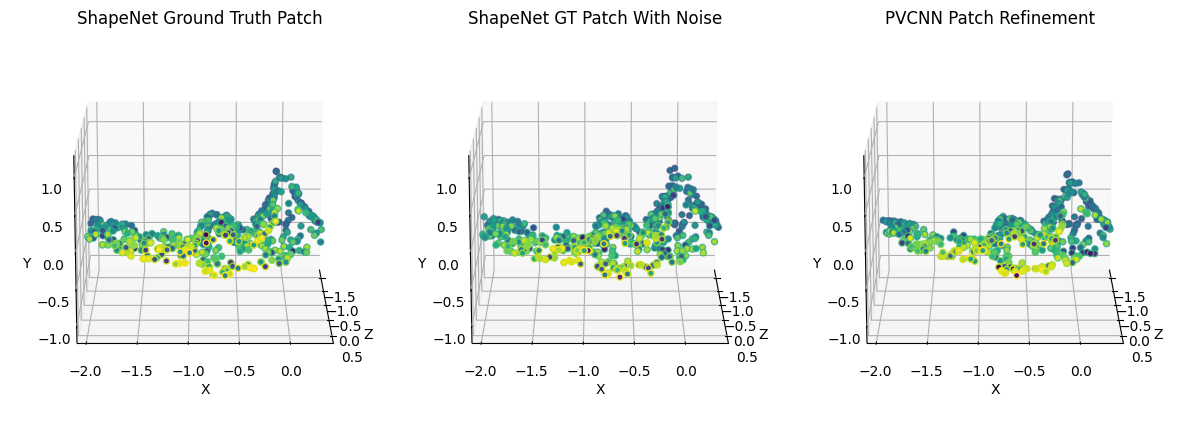

In [90]:
i = 1
for gt, noised_input_sample, output_pvcnn in zip(patched_input, noised_patched_input, output):
    input_np = gt.squeeze().transpose(0, 1).detach().cpu().numpy()
    noised_input_np = noised_input_sample.squeeze().transpose(0, 1).detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().transpose(0, 1).detach().cpu().numpy()

    # output_np = rotate_point_cloud_z(output_np, 90)
    # output_np = rotate_point_cloud_y(output_np, -90)

    fig = visualize_pointcloud_eval_three(input_np, noised_input_np, output_np,"ShapeNet Ground Truth Patch", "ShapeNet GT Patch With Noise", "PVCNN Patch Refinement")
    # save_fig(fig, f"./eval-results/pvcnn-refinement/train-example-{i}.jpg")

    i += 1

    if i > 5:
        break

In [201]:
testing_naive_patching = generate_non_overlapping_patches(input)
testing_naive_patching.shape, testing_naive_patching.transpose(0,1).reshape(20, 2048, 3).shape

(torch.Size([4, 20, 512, 3]), torch.Size([20, 2048, 3]))

In [208]:
test_list = []

for i in range(4):
    test_list.append(testing_naive_patching[i, 0 , :, :])

test_tensor = torch.cat(test_list)
test_tensor.shape

torch.Size([2048, 3])

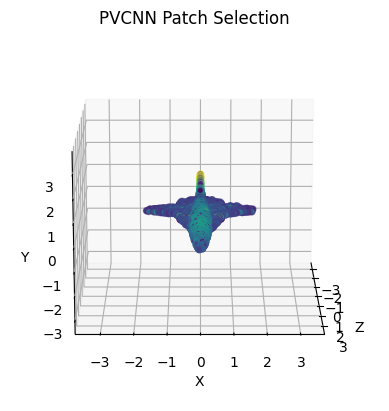

In [209]:
test_tensor_np = test_tensor.squeeze().detach().cpu().numpy()
fig = visualize_pointcloud(test_tensor_np, "PVCNN Patch Selection")

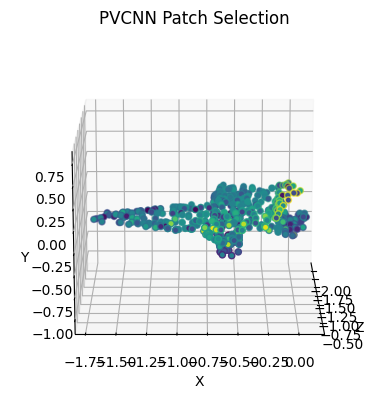

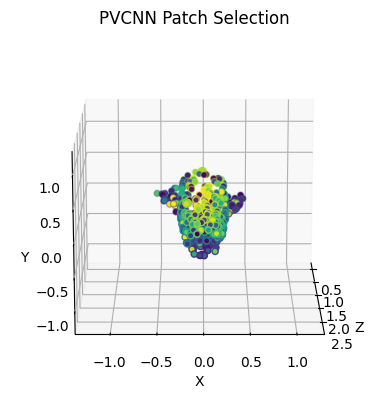

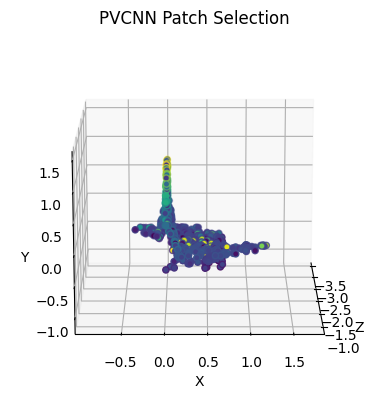

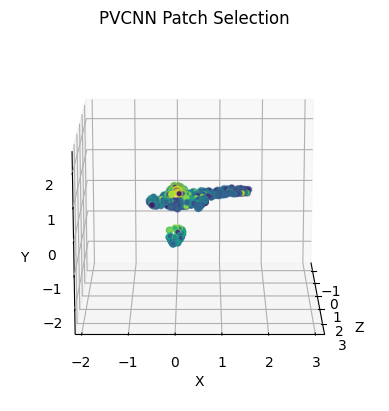

In [204]:
for i in range(4):
    input_np = testing_naive_patching.transpose(0,1)[0, i , :, :].squeeze().detach().cpu().numpy()
    fig = visualize_pointcloud(input_np, "PVCNN Patch Selection")
    # save_fig(fig, f"./eval-results/pvcnn-refinement/train-example-{i}.jpg")

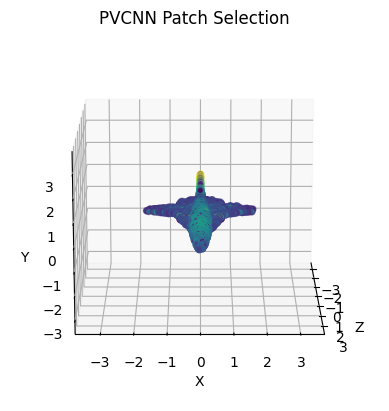

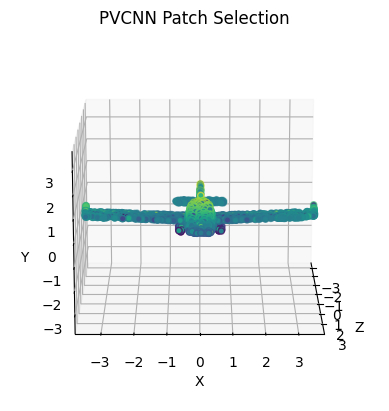

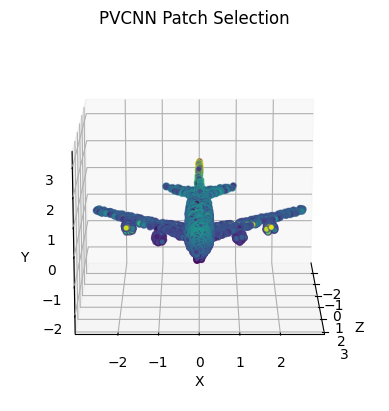

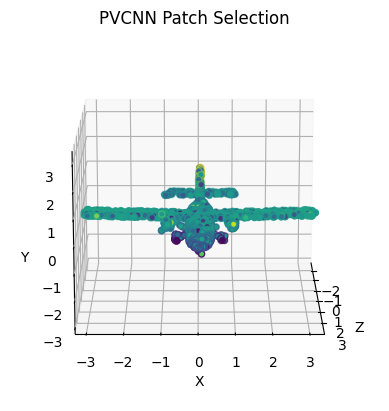

In [202]:
for i in range(4):
    input_np = testing_naive_patching.transpose(0,1).reshape(20, 2048, 3)[i, :, :].squeeze().detach().cpu().numpy()
    fig = visualize_pointcloud(input_np, "PVCNN Patch Selection")
    # save_fig(fig, f"./eval-results/pvcnn-refinement/train-example-{i}.jpg")

# Evaluate the trained PVCNN

In [26]:
model.eval()

total_train_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        # Add noise to the patched input
        noised_patched_input = add_random_noise(patched_input)

        denoised_patches = []
        for noised_patch in noised_patched_input:
            output = model(noised_patch).to("cuda")
            denoised_patches.append(output)

        output = torch.stack(denoised_patches).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)
        
        input_arr.append(input)
        output_arr.append(output)

        loss = chamfer_distance(input, output)
        total_train_loss += loss.item()
        print(f"Batch {i}, CD Loss: {loss.item():.4f}")

average_loss = total_train_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

Batch 0, CD Loss: 0.0042
Batch 1, CD Loss: 0.0048
Batch 2, CD Loss: 0.0057
Batch 3, CD Loss: 0.0037
Batch 4, CD Loss: 0.0043
Batch 5, CD Loss: 0.0075
Batch 6, CD Loss: 0.0044
Batch 7, CD Loss: 0.0037
Batch 8, CD Loss: 0.0043
Batch 9, CD Loss: 0.0035
Batch 10, CD Loss: 0.0047
Batch 11, CD Loss: 0.0037
Batch 12, CD Loss: 0.0041
Batch 13, CD Loss: 0.0048
Batch 14, CD Loss: 0.0044
Batch 15, CD Loss: 0.0039
Batch 16, CD Loss: 0.0040
Batch 17, CD Loss: 0.0054
Batch 18, CD Loss: 0.0044
Batch 19, CD Loss: 0.0049
Batch 20, CD Loss: 0.0046
Batch 21, CD Loss: 0.0040
Batch 22, CD Loss: 0.0062
Batch 23, CD Loss: 0.0047
Batch 24, CD Loss: 0.0043
Batch 25, CD Loss: 0.0040
Batch 26, CD Loss: 0.0044
Batch 27, CD Loss: 0.0041
Batch 28, CD Loss: 0.0043
Batch 29, CD Loss: 0.0043
Batch 30, CD Loss: 0.0037
Batch 31, CD Loss: 0.0050
Batch 32, CD Loss: 0.0057
Batch 33, CD Loss: 0.0044
Batch 34, CD Loss: 0.0050
Batch 35, CD Loss: 0.0035
Batch 36, CD Loss: 0.0051
Batch 37, CD Loss: 0.0043
Batch 38, CD Loss: 0.0

(2048, 3)


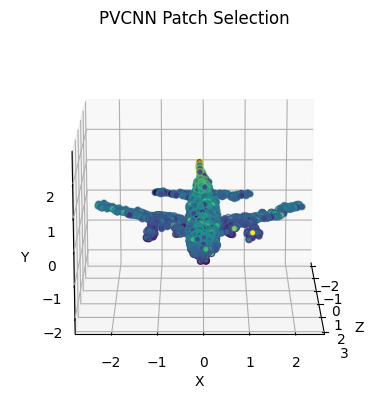

In [28]:
output_np = output[2, :, :].squeeze().detach().cpu().numpy()
print(output_np.shape)
fig = visualize_pointcloud(output_np, "PVCNN Patch Selection")

In [29]:
torch.cat(input_arr).shape, torch.cat(output_arr).shape

(torch.Size([800, 2048, 3]), torch.Size([800, 2048, 3]))

In [ ]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(torch.cat(input_arr)[:400, :, :], torch.cat(output_arr)[:400, :, :], 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

# Let's visualize some more examples from the test set

In [28]:
model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        input = batch["train_points"].to("cuda").transpose(1,2)
        
        # Add noise to the input
        noised_patched_input = add_random_noise(input)
        output = model(noised_patched_input).to("cuda")
        break

In [ ]:
i = 1
for gt, noised_input_sample, output_pvcnn in zip(input, noised_patched_input, output):
    input_np = gt.squeeze().transpose(0, 1).detach().cpu().numpy()
    noised_input_np = noised_input_sample.squeeze().transpose(0, 1).detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().transpose(0, 1).detach().cpu().numpy()

    # output_np = rotate_point_cloud_z(output_np, 90)
    output_np = rotate_point_cloud_y(output_np, -90)

    fig = visualize_pointcloud_eval_three(input_np, noised_input_np, output_np,"ShapeNet Ground Truth", "ShapeNet With Noise", "PVCNN Refinement")
    save_fig(fig, f"./eval-results/pvcnn-refinement/test-example-{i}.jpg")

    i += 1

    if i > 10:
        break

# Final Results

### Training (Last Epoch)
- Training CD Loss: 7.4486
- Validation CD Loss: 1.6459

### Evaluation
- CD Loss: 2.6829

# Let's now try to imrpove the dataset of PVD

In [60]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [28]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [29]:
model.eval()

output_array = []
for batch in dataloader_pvd:
    with torch.no_grad():
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        patch_list = []
        for patch in patched_input:
            output = model(patch).to("cuda")
            patch_list.append(output)

        output = torch.stack(patch_list).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)

    output_array.append(output)

In [30]:
input_pcs = torch.stack(input_array).view(400, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 2048, 3]), torch.Size([400, 2048, 3]))

In [32]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [03:43<00:00,  1.79it/s]

{'lgan_mmd-CD': 0.07184089720249176, 'lgan_cov-CD': 0.33000001311302185, 'lgan_mmd_smp-CD': 0.02361675724387169, 'lgan_mmd-EMD': 0.590373694896698, 'lgan_cov-EMD': 0.3675000071525574, 'lgan_mmd_smp-EMD': 0.2981496751308441, '1-NN-CD-acc_t': 0.5425000190734863, '1-NN-CD-acc_f': 0.9549999833106995, '1-NN-CD-acc': 0.7487499713897705, '1-NN-EMD-acc_t': 0.5874999761581421, '1-NN-EMD-acc_f': 0.8125, '1-NN-EMD-acc': 0.699999988079071}


In [ ]:
loss = {'lgan_mmd-CD': 0.07184089720249176, 
        'lgan_cov-CD': 0.33000001311302185, 
        'lgan_mmd_smp-CD': 0.02361675724387169,
        'lgan_mmd-EMD': 0.590373694896698, 
        'lgan_cov-EMD': 0.3675000071525574, 
        'lgan_mmd_smp-EMD': 0.2981496751308441, 
        '1-NN-CD-acc_t': 0.5425000190734863, 
        '1-NN-CD-acc_f': 0.9549999833106995, 
        '1-NN-CD-acc': 0.7487499713897705, 
        '1-NN-EMD-acc_t': 0.5874999761581421, 
        '1-NN-EMD-acc_f': 0.8125, 
        '1-NN-EMD-acc': 0.699999988079071}

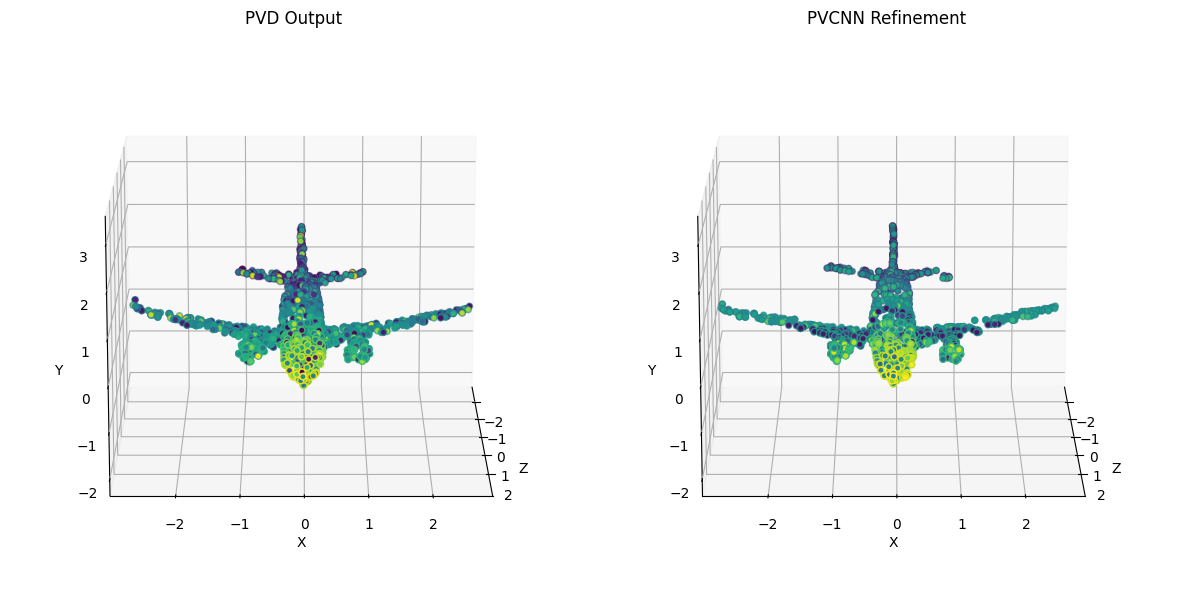

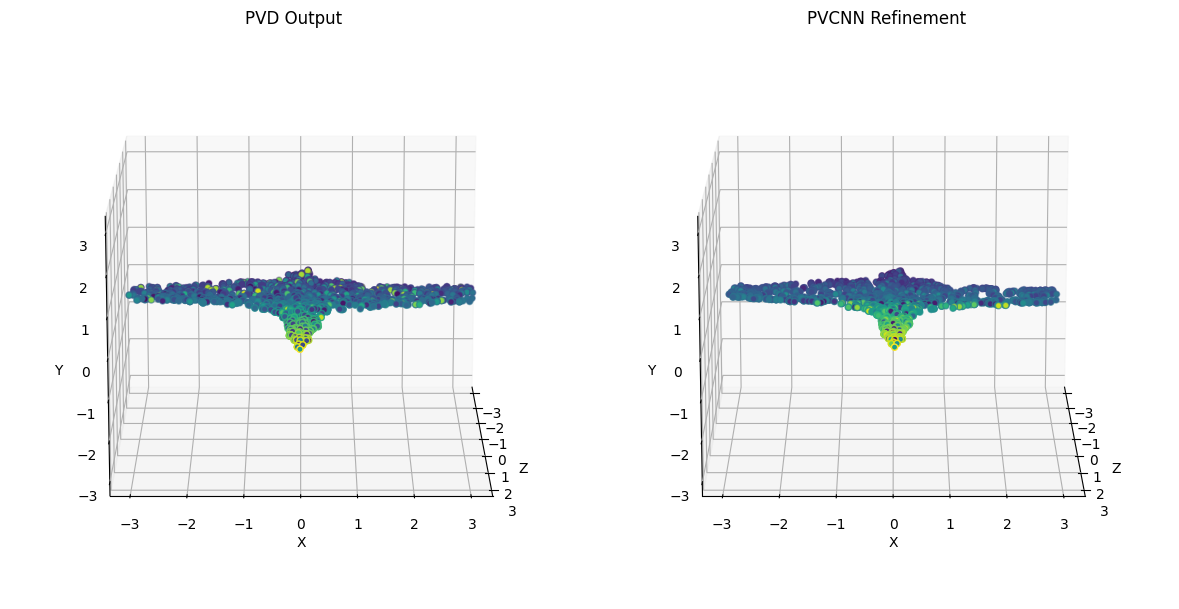

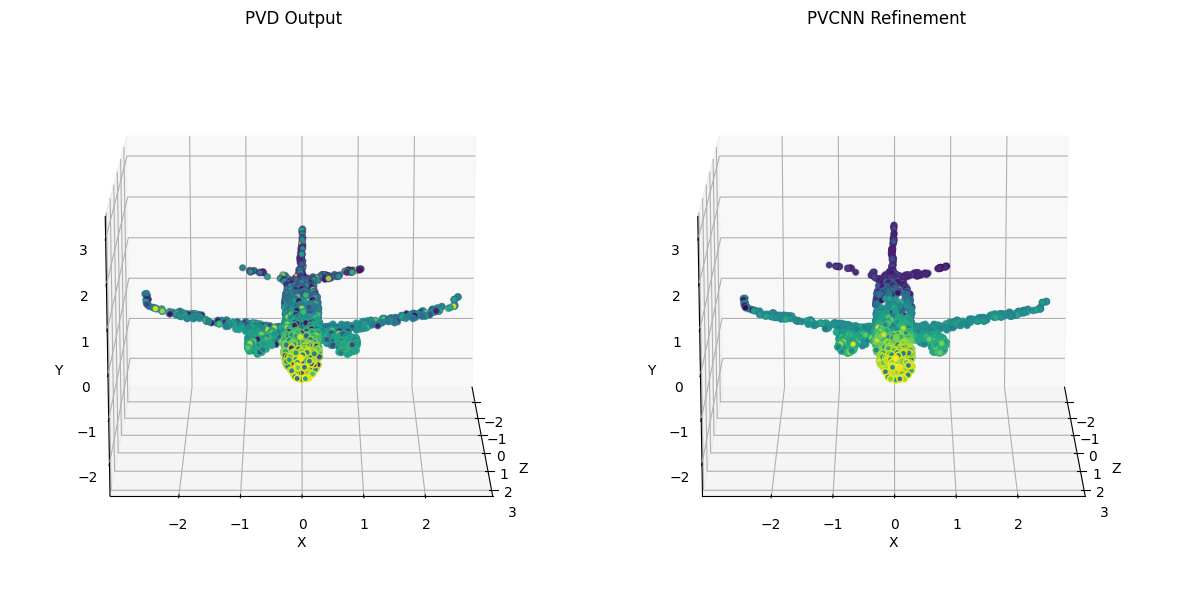

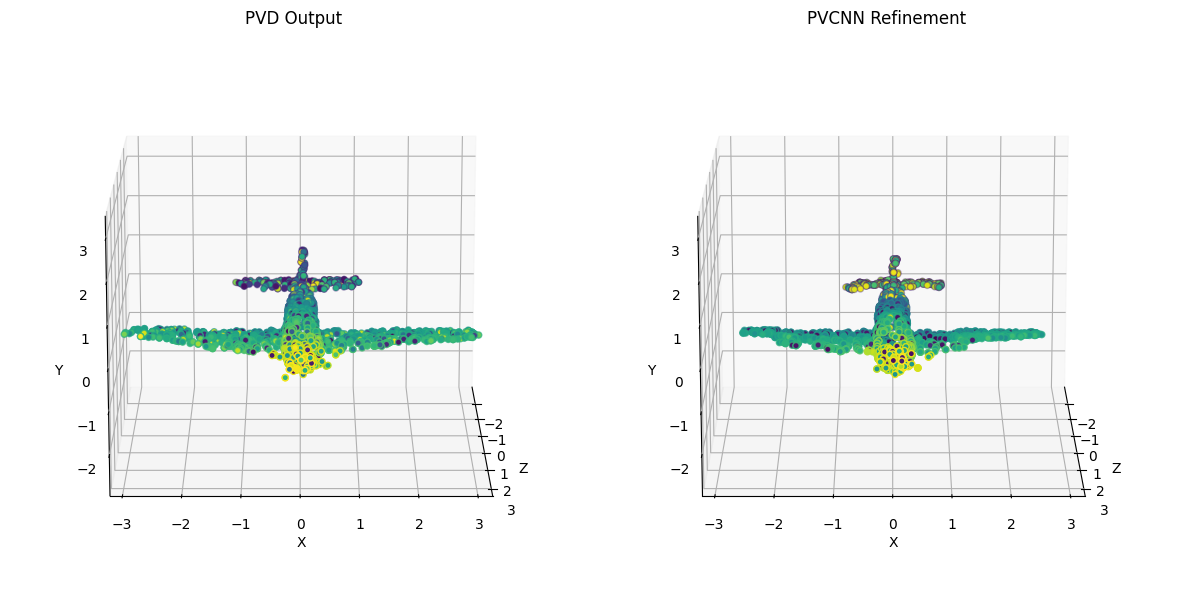

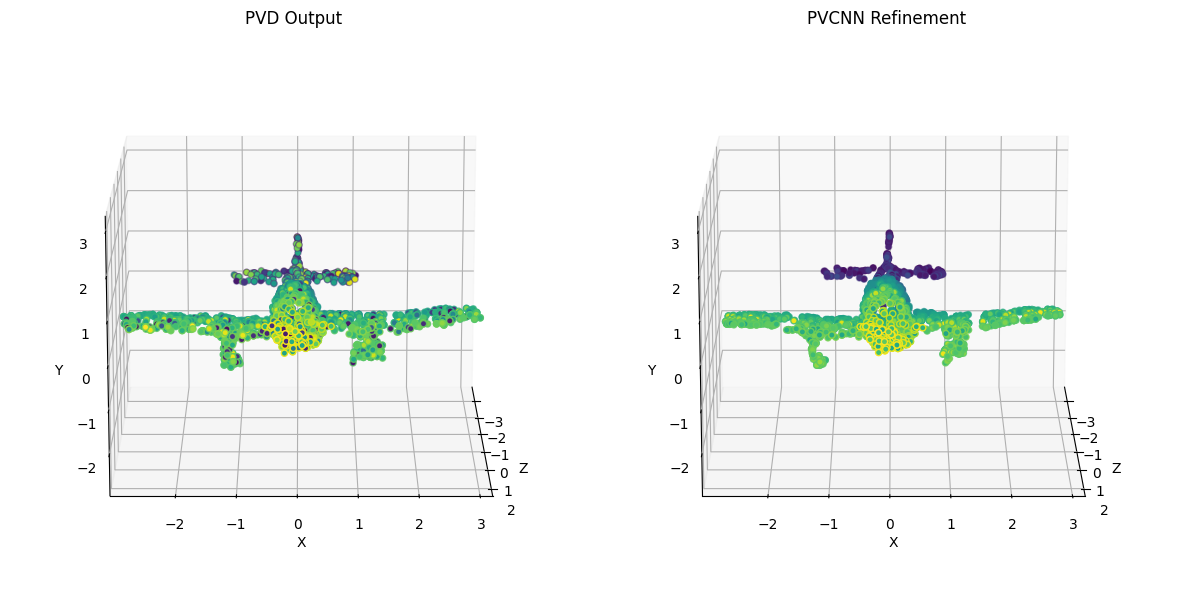

In [35]:
i = 1
for pvd_input, output_pvcnn in zip(input, output):
    input_np = pvd_input.squeeze().detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().detach().cpu().numpy()
    
    fig = visualize_pointcloud_eval(input_np, output_np,"PVD Output", "PVCNN Refinement")
    # save_fig(fig, f"./eval-results/pvcnn-refinement/refined-pvd-output-{i}.jpg")

    i += 1

    if i > 5:
        break